# This notebook trains and evaluates AllLingLog on BGL dataset. 
## Requirements

1. `torch==2.7.1+cu128`
2. `numpy==2.3.1`
3. `pandas==2.3.1`
4. `scikit-learn==1.7.0`
5. `tqdm==4.67.1`
6. `tiktoken==0.9.0`
7. `linformer==0.2.3`
8. `psutil==7.0.0`
9. `matplotlib==3.10.3`



In [1]:
#########################################################################
# This cell read the public log dataset from /logs/BGL.log.
# Tokenizing the logs and creating input features for the model.
# Input features was splitted as test set (70%), validation set (15%) 
# and test set (15%)
##########################################################################
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW 
from torch.nn.utils.rnn import pad_sequence
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score as f1_score_sklearn
from tqdm import tqdm
import time
from datetime import datetime
import pandas as pd
import tiktoken
import random

max_token_length = 4096 # set a initial value for max token length

def set_seed(seed=42):
    """Set random seed for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to {seed}")

# Define Log Dataset
class LogDataset(Dataset):
    def __init__(self, sessions):
        """
        Initializes the dataset with a flat list of logs.

        Parameters:
            sessions: List of dictionaries with keys `input_ids`, `segment_ids`, and `session_label`.
        """
        self.sessions = sessions

    def __len__(self):
        return len(self.sessions)

    def __getitem__(self, idx):
        session = self.sessions[idx]
        return session 


# Define clean function
def clean(text):
    """Cleans a log message by removing special characters, and extra spaces."""
    import re
    import string

    text = re.sub(r'\]|\[|\)|\(|\=|\,|\;', ' ', text)  # Remove specific symbols [ ] ( ) = , and ;
    text = " ".join([word.lower() if word.isupper() else word for word in text.strip().split()])
    text = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', text))
    return " ".join([word.lower().strip() for word in text.strip().split()])



# function to load the pre-trained GPT4 BPE tokenizer 
def load_gpt4_tokenizer():
    print("Loading cl100k_base (GPT-4) tokenizer...")
    tokenizer = tiktoken.get_encoding("cl100k_base")
    return tokenizer


# Tokenize logs with the pre-trained GPT-4 tokenizer 
def tokenize_and_construct_input(log_sequence, tokenizer, max_len=max_token_length):
    """
    Tokenize log messages and construct input IDs and segment IDs.
    
    Parameters:
        log_sequence: List of log messages in a sequence.
        tokenizer: Pre-trained tokenizer  
    
    Returns:
        input_ids: List of token IDs for the entire sequence.
        segment_ids: List of segment IDs corresponding to each token.
    """
    input_ids = []
    segment_ids = []

    allowed_special = {"<|startoftext|>", "<|endoftext|>"}
    bos_token = tokenizer.encode("<|startoftext|>", allowed_special=allowed_special)[0] # get the token id of <|startoftext|>
    eos_token = tokenizer.encode("<|endoftext|>", allowed_special=allowed_special)[0] # get the token id of <|endoftext|>


    # Add bos_token and eos_token markers to the log sequence
    
    for i, log in enumerate(log_sequence):
        # Tokenize the log message
        tokens = tokenizer.encode(log, allowed_special={"<|startoftext|>", "<|endoftext|>"})
        
        # Add bos_token to the first log only in the sequence
        if i == 0:  # First log in sequence
            tokens = [bos_token] + tokens  # <|startoftext|> + log tokens
        tokens = tokens + [eos_token]  # <|endoftext|> appended to the log tokens
        
        # Append tokens to input_ids
        input_ids.extend(tokens)
        
        # Create segment IDs for the current log
        segment_ids.extend([i] * len(tokens))  # Segment ID equals log position

    #if len(input_ids) > max_len:
    #    print(f"Warning: Sequence length {len(input_ids)} exceeds max length {max_len}. Truncating.")

        # Truncate to max_len
        input_ids = input_ids[:max_len]
        segment_ids = segment_ids[:max_len]

    return input_ids, segment_ids



def oversample_with_ratio_control(sessions, beta):
    """
    Oversample the minority class to achieve a specific proportion (beta) in the dataset.

    Parameters:
        sessions: List of dictionaries containing `session_label`.
        beta: Desired proportion of the minority class in the oversampled dataset.

    Returns:
        oversampled_sessions: Balanced list of dictionaries.
    """
    normal_sessions = [s for s in sessions if s["session_label"] == 0]
    anomalous_sessions = [s for s in sessions if s["session_label"] == 1]

    normal_count = len(normal_sessions)
    anomalous_count = len(anomalous_sessions)
    total_count = normal_count + anomalous_count

    if anomalous_count == 0:
        raise ValueError("No samples found in the minority class (anomalous logs).")

    alpha = anomalous_count / total_count

    target_minority_size = int((beta * (1 - alpha) / (1 - beta)) * total_count) 

    new_added_anomalous = target_minority_size - anomalous_count

    if target_minority_size <= anomalous_count:
        print(f"No oversampling needed. Current minority size meets the target proportion.")
        return sessions

    # Perform oversampling with replacement
    new_added_anomalous = np.random.choice(anomalous_sessions, size=new_added_anomalous, replace=True)
    oversampled_sessions = normal_sessions + anomalous_sessions + list(new_added_anomalous)

    # Shuffle the dataset
    np.random.shuffle(oversampled_sessions)

    print(f"Original Minority Samples: {anomalous_count}")
    print(f"New Target Minority Size: {target_minority_size}")
    print(f"New Total Samples: {len(oversampled_sessions)}")

    return oversampled_sessions

   
def create_sessions_with_segment_ids(log_data, tokenizer, windows_size, step_size):
    """
    Process log data into sessions with input IDs and segment IDs.

    Parameters:
        log_data: List of log messages.
        tokenizer: Pre-trained tokenizer.
        windows_size: Number of logs in a sliding window.
        step_size: Step size for sliding window.

    Returns:
        sessions: List of dictionaries containing input IDs and segment IDs.
    """

    sessions = []
    print("Creating sessions...")
    for i in tqdm(range(0, len(log_data) - windows_size, step_size), desc="Processing Sessions"):
        logs_in_session = []  # Reset logs_in_session for each new session
        label = 0  # Initialize as the session label
        for j in range(i, i + windows_size):
            content = log_data[j]

            # Check for an anomaly and update the session label
            if content[0] != "-":  # If the log doesn't start with "-", mark the session as anomalous
                label = 1
            # remove label from log messages
            content = content[content.find(' ') + 1:]
            if clean_log == True:
                content = clean(content.lower())  # Clean the log
            logs_in_session.append(content)

        # Construct input IDs and segment IDs
        input_ids, segment_ids = tokenize_and_construct_input(logs_in_session, tokenizer)
        # Append the session as a dictionary to the sessions list
        sessions.append({
            "input_ids": input_ids,
            "segment_ids": segment_ids,
            "session_label": label
        })

    return sessions


# Updated load_supercomputers function with GPT-2 BPE
def load_supercomputers_with_gpt2_bpe_stratified(
    log_file, 
    train_ratio=0.7, 
    windows_size=20, 
    step_size=20
):
    """
    Load logs, create sessions, then perform a stratified train/test split 
    based on session labels (normal vs. anomalous).
    
    Parameters:
        log_file: Path to the log file.
        train_ratio: Ratio of training data, e.g. 0.7 = 70% for training.
        windows_size: Window size for sliding window.
        step_size: Step size for the sliding window.

    Returns:
        training_sessions: List of dictionaries for training logs.
        test_sessions: List of dictionaries for test logs.
        tokenizer: Pre-trained GPT-2 tokenizer.
    """
    print("Loading logs from:", log_file)
    start_time = time.time()

    # 1) Read all logs
    with open(log_file, mode="r", encoding='utf8') as f:
       logs = [x.strip() for x in tqdm(f, desc="Reading Logs")]

    print(f"Loaded {len(logs)} logs in {time.time() - start_time:.2f} seconds.")

    # 2) Load GPT4 tokenizer
    tokenizer = load_gpt4_tokenizer()

    # 3) Create sessions from ALL logs
    #    Instead of splitting first, we create sessions for the entire log file.
    all_sessions = create_sessions_with_segment_ids(logs, tokenizer, windows_size, step_size)

    
    # 4) calculate the number of length that fit xx% of the sessions 
    # for testing the choosen of max token length
    token_lengths = [len(session["input_ids"]) for session in all_sessions]
    max_len_90 = int(np.percentile(token_lengths, 90))
    max_len_95 = int(np.percentile(token_lengths, 95))
    max_token_length = max(token_lengths)
    print(f"Max tokens in 90% of sessions: {max_len_90}")
    print(f"Max tokens in 95% of sessions: {max_len_95}")
    print(f"Max tokens in 100% of sessions: {max_token_length}") 
    

    # 5) Extract labels for each session
    session_labels = [s["session_label"] for s in all_sessions]

    # 6) Perform stratified split
    train_sessions, temp_sessions = train_test_split(
        all_sessions,
        test_size=(1 - train_ratio),
        stratify=session_labels,
        random_state=42
    )
    
    # Further split the temp_sessions into validation and test sets
    val_ratio = 0.5  # 50% of the temp_sessions for validation
    val_sessions, test_sessions = train_test_split(
        temp_sessions,
        test_size=val_ratio,
        stratify=[s["session_label"] for s in temp_sessions],
        random_state=42
    )
    
    print(f"Number of sessions after sliding window: {len(all_sessions)}")
    print(f"Train sessions: {len(train_sessions)} | Validation sessions: {len(val_sessions)} | Test sessions: {len(test_sessions)}")

    # double check the data pipeline before oversampling 
    train_normal = sum(s['session_label'] == 0 for s in train_sessions)
    train_anomalous = sum(s['session_label'] == 1 for s in train_sessions)
    val_normal = sum(s['session_label'] == 0 for s in val_sessions)
    val_anomalous = sum(s['session_label'] == 1 for s in val_sessions)
    test_normal = sum(s['session_label'] == 0 for s in test_sessions)
    test_anomalous = sum(s['session_label'] == 1 for s in test_sessions)
    print("\n","The ratio of Normal to Animalous befor oversampling")
    print("Train set => Normal:", train_normal, "| Anomalous:", train_anomalous)
    print(f"Anomalous ratio:  {train_anomalous/(train_anomalous+ train_normal):.2f}")
    print("Validation set => Normal:", val_normal, "| Anomalous:", val_anomalous) 
    print(f"Anomalous ratio:  {val_anomalous/(val_anomalous+ val_normal):.2f}")
    print("Test set => Normal:", test_normal, "| Anomalous:", test_anomalous) 
    print(f"Anomaloud ratio:  {test_anomalous/(test_anomalous+ test_normal):.2f}", "\n")
    
    # 6) Oversample only the training sessions
    print("Balancing training data with oversampling...")
    train_sessions = oversample_with_ratio_control(train_sessions, beta)

    # double check the data pipeline after oversampling 
    train_normal = sum(s['session_label'] == 0 for s in train_sessions)
    train_anomalous = sum(s['session_label'] == 1 for s in train_sessions)
    train_total = train_normal + train_anomalous
    val_normal = sum(s['session_label'] == 0 for s in val_sessions)
    val_anomalous = sum(s['session_label'] == 1 for s in val_sessions)
    val_total = val_normal + val_anomalous
    test_normal = sum(s['session_label'] == 0 for s in test_sessions)
    test_anomalous = sum(s['session_label'] == 1 for s in test_sessions)
    test_total = test_normal + test_anomalous
    print("\n","The ratio of Normal to Animalous after oversampling")
    print("Train set => Normal:", train_normal, "| Anomalous:", train_anomalous) 
    print("Train Anomalous ratio: ", train_anomalous/train_total)
    print("Validation set => Normal:", val_normal, "| Anomalous:", val_anomalous) 
    print("Validation Anomalous ratio: ", val_anomalous/val_total)
    print("Test set => Normal:", test_normal, "| Anomalous:", test_anomalous) 
    print("Test Anomalous ratio: ", test_anomalous/test_total , "\n")
    
    print(f"Balanced training data: {len(train_sessions)} samples")
    print(f"Total processing time: {time.time() - start_time:.2f} seconds.")
    
    return train_sessions, val_sessions, test_sessions, tokenizer


# Check if training_sessions is created correctly
def validate_sessions(sessions, tokenizer, windows_size):
    """
    Validates the sessions by printing tokenized and decoded logs.

    Parameters:
        sessions: List of dictionaries with `input_ids`, `segment_ids`, and `session_label`.
        tokenizer: Pre-trained tokenizer.
        windows_size: Expected number of logs in a session (for validation).
    """
    print("=========== Start of Validate Sessions =====================")
    print(f"Number of sessions: {len(sessions)}")
    for idx, session in enumerate(sessions[:5]):  # Check the first 5 sessions
        print(f"\nSession {idx + 1}:")
        print(f"Input IDs: {session['input_ids']}")
        print(f"Segment IDs: {session['segment_ids']}")
        print(f"Session Label: {session['session_label']}")

        # Decode and verify tokenized logs
        decoded_log = tokenizer.decode(session["input_ids"])
        print(f"Decoded Log: {decoded_log}")

        # Verify the number of logs in the session
        num_logs = session['segment_ids'][-1] + 1  # Count logs separated by <|endoftext|>
        print(f"Number of logs in this session: {num_logs}")



log_file = "./logs/BGL.log"
windows_size = 10
step_size = 10
train_ratio = 0.7  # 70% of the data will be used for training
set_seed(42)  # Set random seed for reproducibility
beta = 0.4  # control the ratio of the minority class in the dataset , 0.2 means 20% of the dataset will be the minority class
clean_log = False  # if True, clean the logs by removing special characters and extra spaces

training_sessions, val_sessions, test_sessions, tokenizer = load_supercomputers_with_gpt2_bpe_stratified(
    log_file, 
    train_ratio=train_ratio, 
    windows_size=windows_size, 
    step_size=step_size
)


# Validate sessions
validate_sessions(training_sessions, tokenizer, windows_size)



# Calculate the average and max token length from all sessions (train, val, test)
all_sessions = training_sessions + val_sessions + test_sessions
token_lengths = [len(session["input_ids"]) for session in all_sessions]
print(f"Average tokens per session: {sum(token_lengths) / len(token_lengths):.2f}")
print(f"Max tokens in a session: {max(token_lengths)}")

Random seed set to 42
Loading logs from: ./logs/BGL.log


Reading Logs: 4747963it [00:01, 3135910.21it/s]


Loaded 4747963 logs in 1.52 seconds.
Loading cl100k_base (GPT-4) tokenizer...
Creating sessions...


Processing Sessions: 100%|██████████| 474796/474796 [01:38<00:00, 4806.13it/s] 


Max tokens in 90% of sessions: 891
Max tokens in 95% of sessions: 891
Max tokens in 100% of sessions: 2549
Number of sessions after sliding window: 474796
Train sessions: 332357 | Validation sessions: 71219 | Test sessions: 71220

 The ratio of Normal to Animalous befor oversampling
Train set => Normal: 305042 | Anomalous: 27315
Anomalous ratio:  0.08
Validation set => Normal: 65366 | Anomalous: 5853
Anomalous ratio:  0.08
Test set => Normal: 65366 | Anomalous: 5854
Anomaloud ratio:  0.08 

Balancing training data with oversampling...
Original Minority Samples: 27315
New Target Minority Size: 203361
New Total Samples: 508403

 The ratio of Normal to Animalous after oversampling
Train set => Normal: 305042 | Anomalous: 203361
Train Anomalous ratio:  0.39999960661129064
Validation set => Normal: 65366 | Anomalous: 5853
Validation Anomalous ratio:  0.08218312528959969
Test set => Normal: 65366 | Anomalous: 5854
Test Anomalous ratio:  0.08219601235607975 

Balanced training data: 508403 sa

In [9]:
##############################################################################
# implement the embedding layers 
##############################################################################

cl100k_vocab_size = 100264 # GPT4 BPE
segment_ids_size = windows_size  # for BGL
embedding_dimension = 128
# length_95_percentile = 891 # 95% of the sessions are under 969 tokens long
max_token_length = max_token_length  

class EmbeddingLayer(nn.Module):
    def __init__(self, vocab_size=cl100k_vocab_size, max_seq_len=max_token_length, segment_vocab_size=segment_ids_size, embedding_dim=128):
        super(EmbeddingLayer, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, embedding_dim)          # GPT vocab size
        self.segment_embedding = nn.Embedding(segment_vocab_size, embedding_dim)  # For segment IDs
        self.position_embedding = nn.Embedding(max_seq_len, embedding_dim)     # For position IDs

    def forward(self, input_ids, segment_ids, position_ids=None):
        # Automatically generate position_ids if not provided
        if position_ids is None:
            position_ids = torch.arange(input_ids.size(1), device=input_ids.device).unsqueeze(0).repeat(input_ids.size(0), 1)
        
        E_token = self.token_embedding(input_ids)         # (batch_size, seq_len, embedding_dim)
        E_segment = self.segment_embedding(segment_ids)   # (batch_size, seq_len, embedding_dim)
        E_position = self.position_embedding(position_ids) # (batch_size, seq_len, embedding_dim)
        return E_token + E_segment + E_position


In [10]:
###################################################################
# Construct linear self-attention encoder via linformer
# Final AllLinLog model
###################################################################

from linformer import Linformer
import torch
import torch.nn as nn
max_token_length = max_token_length
# Updated Transformer Encoder Layer using Linformer
class LinformerEncoderLayer(nn.Module):
    def __init__(self, embedding_dim=128, num_heads=2, ff_hidden_dim=128, k=128, dropout=0.1):
        """
        A single Linformer encoder layer.

        Args:
        - embedding_dim: Input embedding dimension.
        - num_heads: Number of attention heads.
        - ff_hidden_dim: Hidden dimension of the feed-forward network.
        - k: Low-rank approximation factor for attention.
        - dropout: Dropout rate.
        """
        super(LinformerEncoderLayer, self).__init__()
        self.self_attention = Linformer(
            dim=embedding_dim,
            seq_len=max_token_length,  # Sequence length from your max_token_length
            depth=1,  # Single depth for this layer
            heads=num_heads,
            k=k,  # Low-rank approximation
            one_kv_head=True,
            share_kv=True
        )
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embedding_dim, ff_hidden_dim),
            nn.ReLU(),
            nn.Linear(ff_hidden_dim, embedding_dim)
        )
        self.norm2 = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Self-attention with residual connection
        attention_output = self.self_attention(x)
        x = self.norm1(x + self.dropout(attention_output))

        # Feed-forward network with residual connection
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_output))

        return x

# Linformer-based Transformer Encoder
class LinformerTransformerEncoder(nn.Module):
    def __init__(self, num_layers=1, embedding_dim=128, num_heads=2, ff_hidden_dim=128, k=128, dropout=0.1):
        """
        Multi-layer Linformer-based Transformer encoder.

        Args:
        - num_layers: Number of Linformer encoder layers.
        - embedding_dim: Input embedding dimension.
        - num_heads: Number of attention heads.
        - ff_hidden_dim: Hidden dimension of the feed-forward network.
        - k: Low-rank approximation factor for attention.
        - dropout: Dropout rate.
        """
        super(LinformerTransformerEncoder, self).__init__()
        self.layers = nn.ModuleList([
            LinformerEncoderLayer(embedding_dim, num_heads, ff_hidden_dim, k, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Final AllLinLog Model
class AllLinLog(nn.Module):
    def __init__(self, vocab_size=cl100k_vocab_size, max_seq_len=max_token_length, segment_vocab_size=20, embedding_dim=128, 
                 num_layers=1, num_heads=2, ff_hidden_dim=128, k=128, num_classes=2, dropout=0.1):
        super(AllLinLog, self).__init__()
        self.embedding_layer = EmbeddingLayer(vocab_size, max_seq_len, segment_vocab_size, embedding_dim)
        self.encoder = LinformerTransformerEncoder(num_layers, embedding_dim, num_heads, ff_hidden_dim, k, dropout)
        self.fc = nn.Linear(embedding_dim, num_classes)  # Final classification layer

    def forward(self, input_ids, segment_ids, position_ids, attention_mask=None):
        embeddings = self.embedding_layer(input_ids, segment_ids, position_ids)  # (batch_size, seq_len, embedding_dim)
        encoder_output = self.encoder(embeddings)  # (batch_size, seq_len, embedding_dim)
        pooled_output = torch.mean(encoder_output, dim=1)  # Average pooling for session-level representation
        logits = self.fc(pooled_output)  # (batch_size, num_classes)
        return logits
    


Random seed set to 42
running with k = 32
Total Parameters: 13693442
Model Size: 52.24 MB
Total Parameters: 13693442
Model Size: 52.24 MB
Input IDs: torch.Size([8, 765]), Segment IDs: torch.Size([8, 765])
Attention Masks: torch.Size([8, 765]), Session Labels: torch.Size([8])
Epoch 1/1
Input IDs: torch.Size([8, 765]), Segment IDs: torch.Size([8, 765])
Attention Masks: torch.Size([8, 765]), Session Labels: torch.Size([8])
Epoch 1/1


Formatted Classification Report:
             precision   recall f1-score  support
Normal         0.99851  0.99621  0.99736  65366.0
Anomalous      0.95869  0.98343  0.97090   5853.0
accuracy       0.99516  0.99516  0.99516      NaN
macro avg      0.97860  0.98982  0.98413  71219.0
weighted avg   0.99524  0.99516  0.99518  71219.0
Train Loss: 0.02906, Train Accuracy: 0.99223
Val Loss: 0.03812, Val Accuracy: 0.99516
Anomalous Precision: 0.95869, Anomalous Recall: 0.98343, Anomalous F1 Score: 0.97090
Training time for one epoch: 13.41 minutes
The Memory initial allocated beform training: 52.24 MB
Memory Used for training in this epoch: 172.96 MB

Learning Rate: 5.0e-04
New best model saved as: best_model/best_model_20250825_192642.pth 

Average Training Time per Epoch: 13.408363310496012 min
Peak GPU Memoryy Allocated: 412.44 MB


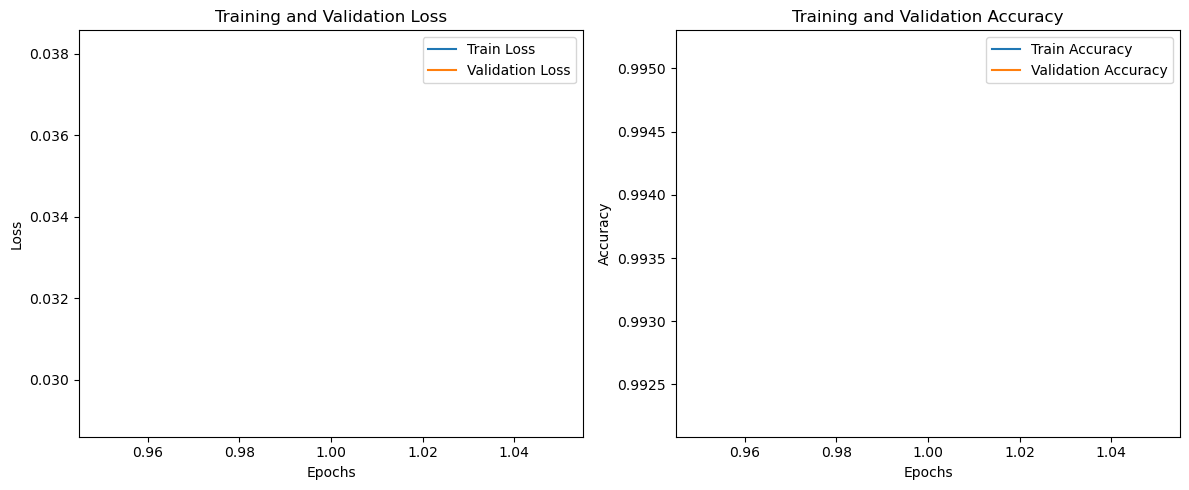

Formatted Classification Report:
             precision   recall f1-score  support
Normal         0.99859  0.99622  0.99740  65366.0
Anomalous      0.95889  0.98428  0.97142   5854.0
accuracy       0.99524  0.99524  0.99524      NaN
macro avg      0.97874  0.99025  0.98441  71220.0
weighted avg   0.99533  0.99524  0.99527  71220.0
Test evaluation result saved to results/test_classification_report_BGL_20250825_192642.csv and results/test_classification_report_BGL_20250825_192642.txt


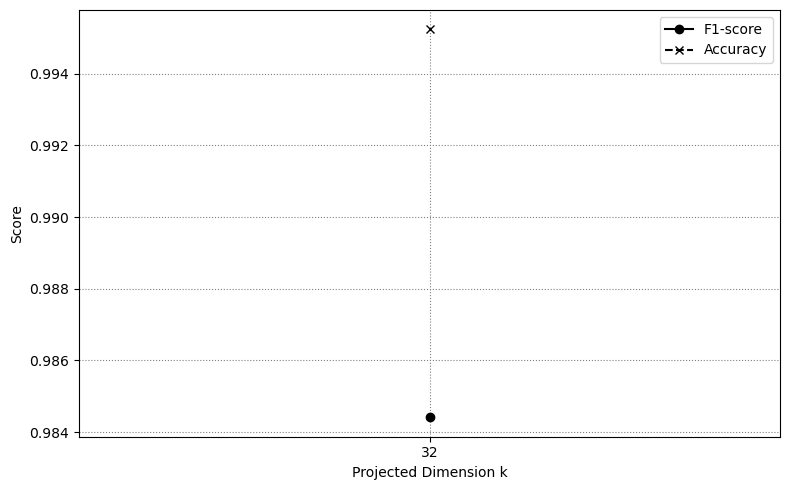

Latest results file: results/results_20250825_192642.txt


In [11]:
##############################################################################
# Create the dataloaders 
# Training and Evaluation Pipeline
# Output is placed into /results
# The best model is saved to /best_model
###############################################################################

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score as f1_score_sklearn
import matplotlib.pyplot as plt
import os
import glob
import datetime
from linformer import Linformer
import psutil
import random
import numpy as np
import gc  # Add garbage collection


def clear_memory():
    """Clear memory cache for MPS/CUDA"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    elif torch.backends.mps.is_available():
        torch.mps.empty_cache()


def generate_classification_report(all_labels, all_preds):
    # Generate the classification report as a dictionary
    target_names = ["Normal", "Anomalous"]  # Adjust based on your dataset's classes
    report_dict = classification_report(
        all_labels, 
        all_preds, 
        target_names=target_names, 
        output_dict=True,
        zero_division=0  # avoid warning for undefined metrics
        )


    # Convert the dictionary to a pandas DataFrame
    report_df = pd.DataFrame(report_dict).transpose()

    # Format numeric columns to desired precision
    report_df['precision'] = report_df['precision'].apply(lambda x: f"{x:.5f}")
    report_df['recall'] = report_df['recall'].apply(lambda x: f"{x:.5f}")
    report_df['f1-score'] = report_df['f1-score'].apply(lambda x: f"{x:.5f}")
    report_df['support'] = report_df['support'].apply(lambda x: int(x) if not pd.isna(x) else "")  # Format support as integer

    # Remove support for the accuracy row
    report_df.loc['accuracy', 'support'] = np.nan  # Use NaN for missing numeric values

    print("Formatted Classification Report:")
    print(report_df)

    # Optionally, save the report to a CSV or text file
    report_df.to_csv('classification_report.csv', index=True)
    return report_df

class Trainer:
    def __init__(self, model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs=10, patience=3, device='cpu'):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion = criterion
        self.num_epochs = num_epochs
        self.patience = patience
        self.device = device
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.total_time = 0
        self.timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        self.best_macro_f1 = 0.0
        self.best_marco_acc = 0.0
        

        # Create necessary folders
        os.makedirs('results', exist_ok=True)
        os.makedirs('best_model', exist_ok=True)

    def train(self):
        best_val_loss = float('inf')
        best_val_f1 = 0.0
        patience_counter = 0   
        results_file = os.path.join('results', f'results_{self.timestamp}.txt')
        best_model_file = os.path.join('best_model', f'best_model_{self.timestamp}.pth')
        total_params, size_mb = compute_model_size(model)
        total_time_minutes = 0 
        memory_initial = 0

        # Clear memory before training
        clear_memory()

        with open(results_file, 'w') as f:
            f.write("Experiment Parameters:\n")
            f.write(f"log_file: {log_file}\n")
            f.write(f"windows_size: {windows_size}\n")
            f.write(f"step_size: {step_size}\n")
            f.write(f"train_ratio: {train_ratio}\n")
            f.write(f"beta: {beta}\n")
            f.write(f"batch_size: {batch_size}\n")
            f.write(f"dropout: {dropout}\n")
            f.write(f"num_layers: {num_layers}\n")
            f.write(f"num_heads: {num_heads}\n")
            f.write(f"k: {k}\n")
            f.write("\n")
            f.write(f"Total Parameters: {total_params}\n")
            f.write(f"Model Size: {size_mb:.2f} MB\n")
            memory_initial = measure_memory()
            epoch_run = 0
            for epoch in range(self.num_epochs):
                start_time = time.time()
                memory_before = measure_memory()
                epoch_run +=1
                msg = f"Epoch {epoch + 1}/{self.num_epochs}"
                print(msg)
                print(msg, file=f)

                # Training Phase
                train_loss, train_acc = self._train_one_epoch()
                epoch_time_minutes = (time.time() - start_time) / 60
                total_time_minutes += epoch_time_minutes

                memory_after = measure_memory()
                if memory_before == memory_after:
                    memory_before = memory_initial

                # Validation Phase
                val_loss, val_acc, macro_f1, Anomalous_val_precision, Anomalous_val_recall, Anomalous_val_f1, report_df = self._validate()

                # Log and Save Metrics
                self.train_losses.append(train_loss)
                self.train_accuracies.append(train_acc)
                self.val_losses.append(val_loss)
                self.val_accuracies.append(val_acc)

            
                # Log to console and file
                log = (
                    f"Train Loss: {float(train_loss):.5f}, Train Accuracy: {float(train_acc):.5f}\n"
                    f"Val Loss: {float(val_loss):.5f}, Val Accuracy: {float(val_acc):.5f}\n"
                    f"Anomalous Precision: {float(Anomalous_val_precision):.5f}, "
                    f"Anomalous Recall: {float(Anomalous_val_recall):.5f}, "
                    f"Anomalous F1 Score: {float(Anomalous_val_f1):.5f}\n"
                    f"Training time for one epoch: {float(epoch_time_minutes):.2f} minutes\n"
                    f"The Memory initial allocated beform training: {memory_initial:.2f} MB\n"
                    f"Memory Used for training in this epoch: {memory_after - memory_before:.2f} MB\n"
                )

                print(log)
                print(log, file=f)

                # Log the full classification report to the results file
                print("\nClassification Report:\n", file=f)
                print(report_df.to_string(), file=f)
                print("------------ END of Epoch --------------\n", file=f)

                # Scheduler Step
                self.scheduler.step(val_loss)
                current_lr = self.optimizer.param_groups[0]['lr']
                msg = f"Learning Rate: {current_lr:.1e}"
                print(msg)
                print(msg, file=f)

                # Early Stopping Logic , can based on val_loss or Anmalous_val_f1
                if (val_loss < best_val_loss) or (Anomalous_val_f1 > best_val_f1):
                    best_val_loss = min(val_loss, best_val_loss)
                    best_val_f1 = max(Anomalous_val_f1, best_val_f1)
                    self.best_macro_f1 = max(macro_f1, self.best_macro_f1)
                    self.best_marco_acc = max(val_acc, self.best_marco_acc)
                    patience_counter = 0
                    torch.save(self.model.state_dict(), best_model_file)
                    msg = f"New best model saved as: {best_model_file} \n"
                    print(msg)
                    print(msg, file=f)
                else:
                    patience_counter += 1
                    if patience_counter >= self.patience:
                        msg = f"Early stopping triggered after {patience_counter} epochs without improvement. \n"
                        print(msg)
                        print(msg, file=f)
                        break
            
            # average training time per epoch 
            avg_time_minutes = total_time_minutes / epoch_run
            msg = f"Average Training Time per Epoch: {avg_time_minutes} min"
            print(msg)
            print(msg, file=f)

            # peak GPU memory allocated
            if torch.cuda.is_available():
                msg = f"Peak GPU Memoryy Allocated: {torch.cuda.max_memory_allocated() / (1024**2):.2f} MB"
                print(msg)
                print(msg, file=f)
            # Plot Training History
            self._plot_training_history()

    def _train_one_epoch(self):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0
        loop = tqdm(self.train_loader, desc="Training", leave=False)

        for batch in loop:
            input_ids, segment_ids, attention_masks, labels = [b.to(self.device) for b in batch]
            self.optimizer.zero_grad()

            logits = self.model(input_ids, segment_ids, attention_masks)
            loss = self.criterion(logits, labels)
            loss.backward()
            #----------addind for reduce overfitting ---------------
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            #--------------------------------------------------------
            self.optimizer.step()

            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item(), accuracy=correct / total)

        return total_loss / len(self.train_loader), correct / total

    def _validate(self):
        self.model.eval()
        total_loss = 0
        all_preds = []
        all_labels = []

        loop = tqdm(self.val_loader, desc="Validation", leave=False)
        with torch.no_grad():
            for batch in loop:
                input_ids, segment_ids, attention_masks, labels = [b.to(self.device) for b in batch]
                logits = self.model(input_ids, segment_ids, attention_masks)
                loss = self.criterion(logits, labels)
                total_loss += loss.item()

                preds = logits.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                #--for debug, show the partial f1 score---
                # Compute partial F1 with current predictions
                partial_f1 = f1_score_sklearn(all_labels, all_preds, pos_label=1,zero_division=0)
                loop.set_postfix(partial_f1=f"{partial_f1:.5f}", loss=loss.item())
                
        # Generate formatted classification report
        report_df = generate_classification_report(all_labels, all_preds)
        # Extract specific metrics
        if "Anomalous" in report_df.index:
            precision = float(report_df.loc["Anomalous", "precision"])
            recall = float(report_df.loc ["Anomalous", "recall"])
            f1_score = float(report_df.loc["Anomalous", "f1-score"])
        else:
            precision, recall, f1_score = 0.0, 0.0, 0.0

        
        # Overall f1-score from report_df
        if "macro avg" in report_df.index:
            macro_f1 = float(report_df.loc["macro avg", "f1-score"])
        else:
            macro_f1 = 0.0

        # Overall accuracy
        accuracy = (np.array(all_preds) == np.array(all_labels)).mean()

        return total_loss / len(self.val_loader), accuracy,macro_f1, precision, recall, f1_score, report_df

    def measure_inference_time(self, input_sample, num_runs=100):
        """measure inference time and memory usage"""

        self.model.to(self.device)
        self.model.eval()
        input_sample = [tensor.to(self.device) for tensor in input_sample]
        with torch.no_grad():
            # measure memory before inference
            memory_before = measure_memory()

            for _ in range(10):    # warm up befor actual benchmarking 
                _ = self.model(*input_sample)
            start_time = time.time()
            for _ in range(num_runs):
                _ = self.model(*input_sample)
            total_time = time.time() - start_time
            # measure memory after inference
            memory_after = measure_memory()

        avg_inference_time = (total_time / num_runs) * 1000  # Convert to milliseconds
        print(f"Average Inference Time: {avg_inference_time:.2f} ms")
        mem_during_inference = memory_after - memory_before
        print(f"Memory Used During Inference: {mem_during_inference:.2f} MB")

        if torch.cuda.is_available():
            GPU_max_mem_during_inference = torch.cuda.max_memory_allocated() / (1024**2)
            print(f"Peak GPU Memory Allocated: {GPU_max_mem_during_inference:.2f} MB")
        return avg_inference_time, mem_during_inference, GPU_max_mem_during_inference

    def _plot_training_history(self):
        epochs = range(1, len(self.train_losses) + 1)

        plt.figure(figsize=(12, 5))
        training_graph = os.path.join('results', f'training_history_{self.timestamp}.png')

        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label='Train Loss')
        plt.plot(epochs, self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        # Plot Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_accuracies, label='Train Accuracy')
        plt.plot(epochs, self.val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.savefig(training_graph)
        plt.show()

# collate_fn for dataloader to handle variable length of session of logs

def collate_fn(batch):
    """
    Custom collate function for training_sessions.

    Args:
    - batch: List of dictionaries with keys "input_ids", "segment_ids", "session_label".

    Returns:
    - input_ids: Padded tensor of shape (batch_size, max_seq_length).
    - segment_ids: Padded tensor of shape (batch_size, max_seq_length).
    - attention_masks: Tensor of shape (batch_size, max_seq_length).
    - session_labels: Tensor of shape (batch_size).
    """
    input_ids = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
    segment_ids = [torch.tensor(item["segment_ids"], dtype=torch.long) for item in batch]
    session_labels = torch.tensor([item["session_label"] for item in batch], dtype=torch.long)
    
    # Pad sequences
    padded_input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
    padded_segment_ids = pad_sequence(segment_ids, batch_first=True, padding_value=0)

    # Clamp padded sequences to max_token_length after padding
    padded_input_ids = padded_input_ids[:, :max_token_length]
    padded_segment_ids = padded_segment_ids[:, :max_token_length]

    
    # Create attention masks: 1 for non-padding, 0 for padding
    attention_masks = (padded_input_ids != 0).long()

    

    return padded_input_ids, padded_segment_ids, attention_masks, session_labels

def compute_model_size(model):
    total_params = sum(p.numel() for p in model.parameters())
    size_mb = total_params * 4 /(1024**2) # assuming 32 bits floating points
    return total_params, size_mb

def measure_memory():
    """Measure GPU and CPU memory usage."""
    if torch.cuda.is_available():
        return torch.cuda.memory_allocated() / (1024 ** 2)  # Convert to MB
    else:
        return psutil.Process().memory_info().rss / (1024 ** 2)  # RAM in MB


def get_latest_result_file(results_dir="results"):
    """Get the most recent output file in the results folder."""
    list_of_files = glob.glob(os.path.join(results_dir, "results_*.txt"))  # Get all result files
    if not list_of_files:
        print("No result files found.")
        return None
    latest_file = max(list_of_files, key=os.path.getctime)  # Get the newest file
    print(f"Latest results file: {latest_file}")
    return latest_file

def load_best_model(model_path, model_class, k, device):
    """
    Load the best saved model from disk.
    
    Args:
        model_path (str): Path to the saved model.
        model_class (torch.nn.Module): Model class to instantiate.
        device (str): Device to load the model onto.
    
    Returns:
        model (torch.nn.Module): Loaded model with trained weights.
    """
    model = model_class(
            vocab_size=cl100k_vocab_size,  # GPT-4 BPE vocab size
            segment_vocab_size=windows_size,  # For BGL and Thunderbird
            max_seq_len=max_token_length,
            embedding_dim=embedding_dim, num_layers=num_layers, 
            num_heads=num_heads, k=k, ff_hidden_dim=ff_hidden_dim, num_classes=2,   
            dropout=dropout
    ).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    model.eval()
    print(f"Loaded best model from {model_path}")
    return model

# Label Smoothing Loss Implementation
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        """
        smoothing: amount of smoothing (e.g., 0.1 means 10% smoothing)
        """
        super().__init__()
        self.smoothing = smoothing

    def forward(self, logits, target):
        num_classes = logits.size(-1)
        # Convert target to one-hot encoding with smoothing
        with torch.no_grad():
            true_dist = torch.zeros_like(logits)
            true_dist.fill_(self.smoothing / (num_classes - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), 1.0 - self.smoothing)
        return torch.mean(torch.sum(-true_dist * F.log_softmax(logits, dim=-1), dim=-1))

# train and validate 

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
#max_token_length = length_95_percentile  # 95% of the sessions are under 969 tokens long
max_token_length = max_token_length # 2756 for BGL.log

batch_size = 8
dropout = 0.5     
embedding_dim = 128
ff_hidden_dim = 128
num_layers = 1
num_heads = 4
num_epochs = 50 # 50 for BGL evualtion
seed = 42  # Set a seed for reproducibility


def set_seed(seed=42):
    """Set random seed for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to {seed}")
    
if __name__ == "__main__":
    testset_results=[]
    k_valuse = [32,]  

    for k in k_valuse: 
        set_seed(seed)
        print(f"running with k = {k}") 
        
        model = AllLinLog(
            vocab_size=cl100k_vocab_size,  # GPT-4 BPE vocab size
            segment_vocab_size=windows_size,  # For BGL and Thunderbird
            max_seq_len=max_token_length,
            embedding_dim=embedding_dim, num_layers=num_layers, 
            num_heads=num_heads, k=k, ff_hidden_dim=ff_hidden_dim, num_classes=2,   
            dropout=dropout
        ).to(device)

        total_params, size_mb = compute_model_size(model)
        print(f"Total Parameters: {total_params}")
        print(f"Model Size: {size_mb:.2f} MB")

        #optimizer = optim.Adam(model.parameters(), lr=5e-4)   
        optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-2, eps=1e-8) # validataiton get improved after this change, lr 5e-4

        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20)

        # criterion = nn.CrossEntropyLoss()
        class_weights = torch.tensor([1.0, 4.0]).to(device) # Adjust weights for class imbalance, 1.0 for normal, 4.0 for anomalous
        criterion = nn.CrossEntropyLoss(weight=class_weights)

        train_dataset = LogDataset(training_sessions)
        val_dataset = LogDataset(val_sessions)
        test_dataset = LogDataset(test_sessions)

        train_loader = DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            collate_fn=collate_fn, 
            shuffle=True, 
            pin_memory=True  # Optimize data transfer to GPU
            )

        val_loader = DataLoader(
            val_dataset, 
            batch_size=batch_size, 
            collate_fn=collate_fn, 
            pin_memory=True  # Optimize data transfer to GPU
        )

        test_loader = DataLoader(
            test_dataset, 
            batch_size=batch_size, 
            collate_fn=collate_fn, 
            pin_memory=True  # Optimize data transfer to GPU
        )


        # Verify data
        for batch in train_loader:
            input_ids, segment_ids, attention_masks, session_labels = batch
            print(f"Input IDs: {input_ids.shape}, Segment IDs: {segment_ids.shape}")
            print(f"Attention Masks: {attention_masks.shape}, Session Labels: {session_labels.shape}")
            break
        
        trainer = Trainer(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            optimizer=optimizer,
            scheduler=scheduler,
            criterion=criterion,
            num_epochs=num_epochs,  
            patience=30,   
            device=device
        )

        trainer.train()

        # After training, evaluate the best model on the test set for unbiased metrics
        def evaluate_on_test_set(trainer, test_loader, dataset_name=None):
            trainer.model.eval()
            all_preds = []
            all_labels = []
            with torch.no_grad():
                for batch in tqdm(test_loader, desc="Evaluating on Test Set", leave=False):
                    input_ids, segment_ids, attention_masks, labels = [b.to(trainer.device) for b in batch]
                    logits = trainer.model(input_ids, segment_ids, attention_masks)
                    preds = logits.argmax(dim=1)
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
            report_df = generate_classification_report(all_labels, all_preds)
            # Save the test evaluation result to a CSV file with timestamp and dataset name if provided, in the 'results' folder
            dataset_str = f"_{dataset_name}" if dataset_name else ""
            test_report_filename = os.path.join('results', f'test_classification_report{dataset_str}_{trainer.timestamp}.csv')
            report_df.to_csv(test_report_filename, index=True)
            # Also save the pretty printed report to a .txt file
            txt_report_filename = os.path.join('results', f'test_classification_report{dataset_str}_{trainer.timestamp}.txt')
            with open(txt_report_filename, 'w') as f:
                f.write("Unbiased Test Set Classification Report:\n\n")
                f.write(report_df.to_string())
            print(f"Test evaluation result saved to {test_report_filename} and {txt_report_filename}")
            return report_df

        # Load the best model before test evaluation
        best_model_path = os.path.join('best_model', f'best_model_{trainer.timestamp}.pth')
        trainer.model.load_state_dict(torch.load(best_model_path, map_location=trainer.device))
        trainer.model.eval()

        # Now evaluate on the test set
        test_report_df = evaluate_on_test_set(trainer, test_loader, dataset_name='BGL')
        
        # Extract test set metrics
        test_macro_f1 = float(test_report_df.loc["macro avg", "f1-score"])
        test_accuracy = float(test_report_df.loc["accuracy", "f1-score"])  # accuracy is stored in f1-score column for accuracy row

        testset_results.append({
            "k": k,
            "macro_f1": test_macro_f1,
            "test_acc": test_accuracy,
        })


# Convert results to DataFrame
results_df = pd.DataFrame(testset_results)
results_df.to_csv("ablation_k_results.csv", index=False)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(results_df["k"], results_df["macro_f1"], color='black', linestyle='-', marker='o', label="F1-score")
plt.plot(results_df["k"], results_df["test_acc"], color='black', linestyle='--', marker='x', label="Accuracy")

plt.xscale("log", base=2)
plt.xticks(results_df["k"], labels=results_df["k"])

plt.xlabel("Projected Dimension k")
plt.ylabel("Score")
#plt.title("AllLinLog: Effect of k on Performance")
plt.grid(True, linestyle=':', color='gray')
plt.legend()
plt.tight_layout()
plt.savefig("ablation_plot_macro_f1_acc_bw.png")
plt.show()

# Append output summary to the most recent result file
result_file = get_latest_result_file()
if result_file:
    with open(result_file, 'a') as f:
        f.write("\nAblation Study Completed\n")
        f.write("Saved CSV: ablation_k_results.csv\n")
        f.write("Saved Plot: ablation_plot_macro_f1_acc.png\n")
        f.write("Results Summary:\n")
        f.write(results_df.to_string(index=False))
        f.write("\n\n")
        f.write("End of Ablation Study\n")